In [1]:
%load_ext autoreload
%autoreload 2

## Load data

In [2]:
# Utils
from joblib import Parallel, delayed
from tqdm.autonotebook import tqdm
from datetime import datetime
import json
from IPython.display import display, Audio
from pathlib2 import Path

# data libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

/tmp/ipykernel_288092/3377489687.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# wrapper lib
from avgn.utils.paths import DATA_DIR, ensure_dir

DATA_DIR = Path('./data')
DSLOC = DATA_DIR / 'raw' / 'fruitbat'

PROJECT_DIR set on:  /data0/home/h21/luas6629/Thesis


In [4]:
# annotations
annotations =  pd.read_csv(DSLOC/'Annotations.csv')

annotations = annotations.astype({
    'FileID' : int,
    'Emitter' : int,
    'Addressee' : int,
    'Context' :int,
    'Emitter pre-vocalization action' : int,
    'Addressee pre-vocalization action': int,
    'Emitter post-vocalization action' : int,
    'Addressee post-vocalization action' : int,
    'Start sample': float,
    'End sample' : float
})

len(annotations)

91080

In [5]:
# file info
""" fruit bat db is malformed. 
Recreate the db with proper columns.
"""

with open(DSLOC/'FileInfo.csv', 'r') as temp_f:
    # get No of columns in each line
    col_count = [ len(l.split(",")) for l in temp_f.readlines() ]

### Generate column names  (names will be 0, 1, 2, ..., maximum columns - 1)
column_names = [i for i in range(0, max(col_count))]

### Read csv
file_info = pd.read_csv(DSLOC/'FileInfo.csv', header=None, delimiter=",", names=column_names)
file_info, file_info.columns = file_info[1:] , file_info.iloc[0]

# recreate the header
samples_boundaries = np.arange(1, 1 + file_info.shape[1] - 6)
voice_starts = samples_boundaries[::2]
voice_ends = samples_boundaries[1::2]
col_samples_boundaries = { val : float for pair in zip(['voice_start_sample_{}'.format(i + 1)for i in range(len(voice_starts))  ], 
        ['voice_end_sample_{}'.format(i + 1) for i in range(len(voice_ends))  ]) for val in pair }

col_names = ['FileID','Treatment ID','File name','File folder','Recording channel','Recording time'] + \
    [ val for pair in zip(['voice_start_sample_{}'.format(i + 1)for i in range(len(voice_starts))  ], 
        ['voice_end_sample_{}'.format(i + 1) for i in range(len(voice_ends))  ]) for val in pair]

columns_types = {
    'FileID' : int,
    'Treatment ID' : int,
    'File name' : str,
    'File folder' : str,
    'Recording channel' : int,
    'Recording time' : 'datetime64[ms]',
} | col_samples_boundaries
 

# set the new header
file_info.columns = columns_types.keys()


#ensure datatypes are meaningful
file_info = file_info.astype(columns_types)

# set index
file_info.set_index('FileID', inplace=True)

# shape
file_info.shape

/tmp/ipykernel_288092/2238319843.py:14: DtypeWarning: Columns (0,1,4,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  file_info = pd.read_csv(DSLOC/'FileInfo.csv', header=None, delimiter=",", names=column_names)


(293238, 331)

In [6]:
# test file

sample_rawdata = 'files102'
samples_files_info = file_info[file_info['File folder'].values == sample_rawdata]


exnm = 56
wav_loc = DSLOC/'zip_contents'/ sample_rawdata /  samples_files_info['File name'].values[exnm]
wav_info = file_info[file_info['File name'] == wav_loc.name]

In [7]:
# vocalizations from Emitter 215

emitter = 215
sample_annotations = annotations[annotations.Emitter == emitter]

# add Duration column
sr = 250000
sample_annotations.loc[:,'Duration'] = 1/sr * (sample_annotations['End sample']  - sample_annotations['Start sample'])

/tmp/ipykernel_288092/2994222486.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_annotations.loc[:,'Duration'] = 1/sr * (sample_annotations['End sample']  - sample_annotations['Start sample'])


In [8]:
# test file

sample_files = file_info.query(f'FileID in {sample_annotations["FileID"].values.tolist()}')
sample_files.reset_index(inplace=True)

sample_file = sample_files.iloc[3].to_frame().T

In [9]:
sample_file[F

SyntaxError: incomplete input (2122971577.py, line 1)

In [ ]:
sequences_specs_dict = dict()
for i, sample_file in sample_files.head(10).iterrows():
    sample_file = sample_file.to_frame().T
    try:
        sequences_specs_dict[ sample_file[ 'FileID'   ].values[0]] = stack_segments(sample_file)
    except:
        pass

In [ ]:
for k, v in sequences_specs_dict.items():
    x = np.zeros((1025,512))
    x[:, :v.shape[1]] = v
    sequences_specs_dict[k] = x

In [ ]:
for k, v in sequences_specs_dict.items():
    sequences_specs_dict[k] = v.flatten()

In [211]:
x = np.zeros((1025, 145))
x[:, :144] = v

In [212]:
np.zeros((1025,512))

(1025, 145)

In [188]:
# zero padding on the right

max_shape = max([len(v) for k, v in sequences_specs_dict.items()])
    
for k, array in sequences_specs_dict.items():
    # padding right with 0
    x = np.zeros(max_shape, )
    x[:array.shape[0] ] = array
    # update
    sequences_specs_dict[k] = x
    

ValueError: could not broadcast input array from shape (1025,269) into shape (1025,)

In [ ]:
sequence_spec_data = pd.DataFrame.from_dict(sequences_specs_dict).T

In [183]:
import umap
import umap.plot

In [221]:
reducer = umap.UMAP()

In [222]:
mapper = umap.UMAP().fit(list(sequences_specs_dict.values()))

/data0/home/h21/luas6629/venv/lib/python3.10/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


/data0/home/h21/luas6629/venv/lib/python3.10/site-packages/umap/plot.py:448: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

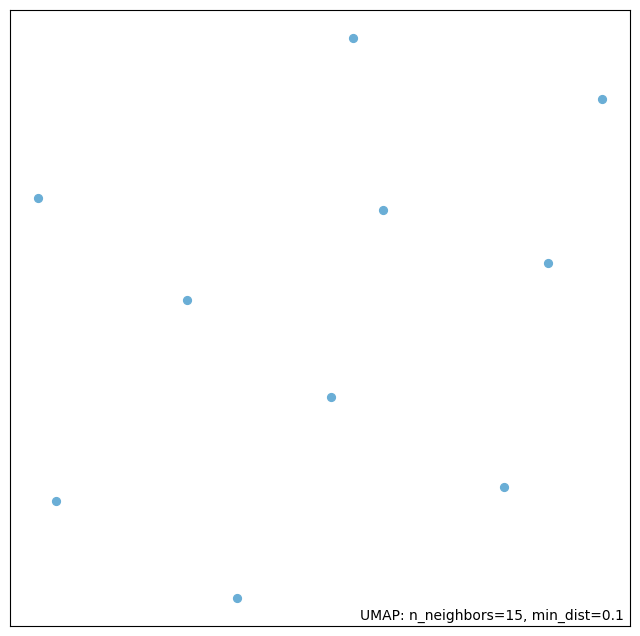

In [223]:
umap.plot.points(mapper)

In [46]:
wav_loc = DSLOC/'zip_contents'/ sample_file['File folder'] /  sample_file['File name']
wav_info = file_info[file_info['File name'] == wav_loc.name]

## Load file test

In [47]:
from avgn.signalprocessing.spectrogramming import *
from avgn.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn.visualization.spectrogram import visualize_spec, plot_spec

from avgn.utils import hparams

In [96]:
# load file

rate, data = load_wav(wav_loc)
print(rate, len(data))

start_times = sample_file.loc[:, sample_file.columns.str.startswith('voice_start_')].dropna(axis=1).values[0]
end_times = sample_file.loc[:, sample_file.columns.str.startswith('voice_end_')].dropna(axis=1).values[0]

assert(len(start_times) == len(end_times))

250000 557904


In [51]:
# load segment
i = 2
segment = data[ int(start_times[ i]) : int(end_times[i]) ]


In [52]:
# load params
bat_hparams = hparams.HParams()

bat_hparams.n_fft = 2048
bat_hparams.hop_length_ms = 1
bat_hparams.win_length_ms = 7

In [53]:
# Spectrograms

In [58]:
spectrogram(segment, rate, bat_hparams)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04402387, 0.07503104, 0.05647445, ..., 0.        , 0.        ,
        0.0346866 ],
       [0.01560553, 0.02950148, 0.02998713, ..., 0.0455906 , 0.02117873,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.0248306 , 0.        ,
        0.        ]])

In [185]:
def stack_segments(wav_info):
    
    start_times = wav_info.loc[:, wav_info.columns.str.startswith('voice_start_')].dropna(axis=1).values[0]
    end_times = wav_info.loc[:, wav_info.columns.str.startswith('voice_end_')].dropna(axis=1).values[0]

    specs = []
    for i in range(len(start_times)):
        segment = data[ int(start_times[ i]) : int(end_times[i]) ]
        specs.append( spectrogram(segment, rate, bat_hparams) )
        
    return np.column_stack(specs)

In [80]:
np.column_stack([np.array([3,2]),np.array([2,3])])

array([[3, 2],
       [2, 3]])

In [145]:
stack_segments(wav_info).flatten().shape

(421275,)